# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline

import torch
import numpy as np
from torch import optim
import torchvision.utils
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

import config
from utils import imshow
from models import SiameseNetwork
from training import trainSiamese,inferenceSiamese
from datasets import SiameseNetworkDataset
from loss_functions import ContrastiveLoss

# generate_csv(config.training_dir)

import os
if not os.path.exists('state_dict'):
    os.makedirs('state_dict')

## Using Image Folder Dataset

In [2]:
siamese_dataset = SiameseNetworkDataset(training_dir=config.training_dir,
                                        training_csv=config.training_csv,
                                        transform=transforms.Compose([transforms.Resize((config.img_height,config.img_width)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

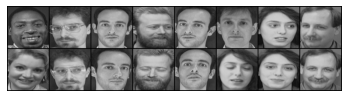

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [3]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Training Time!

In [4]:
# Split the dataset into train, validation and test sets
num_train = round(0.8*siamese_dataset.__len__())
num_validate = round(0.1*siamese_dataset.__len__())
num_test = siamese_dataset.__len__()-num_train-num_validate
siamese_train, siamese_valid, siamese_test = random_split(siamese_dataset, [num_train,num_validate,num_test])
train_dataloader = DataLoader(siamese_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=config.train_batch_size)
valid_dataloader = DataLoader(siamese_valid,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

In [5]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = config.learning_rate )

In [6]:
net, train_loss_history, valid_loss_history,dict_name = trainSiamese(net,criterion,optimizer,train_dataloader,
             valid_dataloader,config.train_number_epochs,do_show=True)

Epoch  0  training


100%|███████████████████████████████████████████| 65/65 [00:02<00:00, 24.97it/s]


Epoch  0  validating


100%|███████████████████████████████████████▉| 323/324 [00:01<00:00, 222.43it/s]


KeyboardInterrupt: 

## Testing

In [ ]:
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load(os.path.join("state_dict",dict_name)))
net.eval()

test_dataloader = DataLoader(siamese_test,num_workers=8,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

test_loss, test_er = inferenceSiamese(net,criterion,test_dataloader)
print("Test loss: %.4f\t Test error: %.4f"
      %(test_loss, test_er))


for i in range(3):
    label = 0
    while label == 0:
        x0,x1,label = next(dataiter)
        label = label.detach().cpu().numpy()[0][0]

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}\nLabel: {}'.format(euclidean_distance.item(),'Different'))

for i in range(3):
    label = 1
    while label == 1:
        x0,x1,label = next(dataiter)
        label = label.detach().cpu().numpy()[0][0]

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}\nLabel: {}'.format(euclidean_distance.item(),'Same'))

